# Клепиков Никита
Вариант 7

Группа 6132

## 1. DataFrame с признаками и их информативностью, отсортированный по убыванию

Подключаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier

Чтение .npy файла и создание DataFrame объекта выполняется следующей командой:

`specter = np.load('7.npy')`

`mask = np.load('7_mask.npy')`



In [2]:
specter = np.load('7.npy')
mask = np.load('7_mask.npy')

Создаём список всех позиций (y, x) для гиперспектра

In [3]:
height = specter.shape[0]
width = specter.shape[1]
ordered_positions = np.array(np.meshgrid(np.arange(height), np.arange(width))).T.reshape(-1, 2)

Перемешиваем и разделяем данные позиции

In [9]:
train_indices, test_indices = train_test_split(ordered_positions, train_size=0.05, shuffle=True)

#### Описание данных
<pre>
У нас есть гиперспектр (3Д Тензор) со следующими размерностями (512, 217, 224).
Где     224 - число слоев (признаков); 
        512x217 - высота и ширина.
</pre>

Каждый слой гиперспектра соответствует определенной [длине волны](https://ru.wikipedia.org/wiki/%D0%94%D0%BB%D0%B8%D0%BD%D0%B0_%D0%B2%D0%BE%D0%BB%D0%BD%D1%8B)

Для вышеупомянутого спектра 10ый, 16ый и 35ый слои соответствуют синей, зелёной и красной компоненте цветовой модели RGB и могут быть использованы для формирования цветного изображения.

In [10]:
specter.shape, mask.shape

((512, 512, 237), (512, 512))

Выберем тренировочные и тестовые выборки

In [11]:
x_train = []
y_train = []
x_test = []
y_test = []

In [12]:
for idx in train_indices:
    x_train.append(specter[idx[0], idx[1], ::])
    y_train.append(mask[idx[0], idx[1]])    
    
for idx in test_indices:
    x_test.append(specter[idx[0], idx[1], ::])
    y_test.append(mask[idx[0], idx[1]])    
    
x_train = np.array(x_train, copy=False)
y_train = np.array(y_train, copy=False)
x_test = np.array(x_test, copy=False)
y_test = np.array(y_test, copy=False)

In [13]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((65536, 237), (65536,), (196608, 237), (196608,))

Масштабируем данные

In [19]:
mms = MinMaxScaler(feature_range=(0, 10))
x_test = mms.fit_transform(x_test, y_test)
x_train = mms.transform(x_train)

`ExtraTreeClassifier` сам по себе не является методом отбора информативных признаков. Однако он *может* быть использовать для определения коэффициентов важности (информативности) признаков, которые могут быть использованы для выбора наиболее информативных признаков.

In [20]:
model = ExtraTreesClassifier()
model = model.fit(x_train, y_train)

Создадим DataFrame из полученных значений `feature_importances_`. И выведем 10 признаков с наибольшими соответствующими значениями информативности.

In [21]:
best_features = pd.DataFrame(data=model.feature_importances_, columns=['feature_importance'])

In [22]:
best_features.nlargest(10, 'feature_importance')

,feature_importance
147,0.011615
149,0.011014
165,0.009654
148,0.008489
163,0.008319
174,0.008238
164,0.007838
172,0.007802
91,0.007792
78,0.007706


## 2. График, показывающий результат оценки зависимости точности модели и числа выбранных признаков

Соберём результаты оценки

In [23]:
number_of_features_list = list(range(1, 11))
accuracy_list = []

In [24]:
# оценим точность для каждого количества функций
for number in number_of_features_list:
    # выберите количество (number) наилучших функций для обучения
    features = list(best_features.nlargest(number, 'feature_importance').index)
    accuracy = 0
    tests_count = 3

    # вычислим среднюю точность по (tests_count) экспериментам
    for i in range(tests_count):
        model = MLPClassifier(max_iter=400, random_state=i*10)
        # проверяем соответстветствие набора обучающих данных только с выбранными функциями
        model.fit(x_train[:,features], y_train)
        # прогнозируем из набора данных тестирования только с выбранными функциями
        y_pred = model.predict(x_test[:,features])
        # оцениваем точность для текущей итерации
        accuracy += accuracy_score(y_test, y_pred)
        
    accuracy /= tests_count
    accuracy_list.append(accuracy)

Построим график, показывающий результат оценки зависимости точности модели и числа выбранных признаков

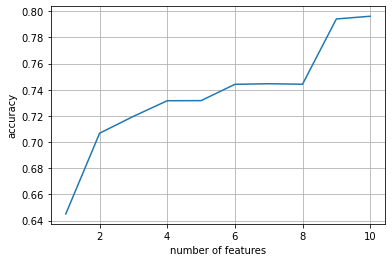

In [25]:
plt.plot(number_of_features_list, accuracy_list)
plt.grid()
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.show()

# 3. Таблица, содержащая f1-score, precision, и recall, полученные для лучшей обученной модели

Создаём модель, используя выбор функций и перекрестную проверку, и обучаем её на обучающем наборе

In [26]:
model = MLPClassifier(max_iter=400, random_state=0)

In [27]:
parameters = {
    'hidden_layer_sizes': [(50,), (100,), (150,)]
}

estimator: объект оценщика, который вы создали

params_grid: объект словаря, содержащий гиперпараметры, которые вы хотите попробовать

scoring: метрика оценки, которую вы хотите использовать, вы можете просто передать действительную строку / объект метрики оценки

refit:
Если при выборе лучшего оценщика есть соображения, отличные от максимального балла, refit может быть настроен на функцию, которая возвращает выбранный best_index_ с заданным cv_results_. В этом случае best_estimator_ и best_params_ будут установлены в соответствии с возвращенным best_index_, в то время как атрибут best_score_ будет недоступен.
Переоборудованный оценщик доступен в атрибуте best_estimator_ и позволяет использовать прогноз непосредственно в этом экземпляре GridSearchCV.

In [28]:
search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring=['f1_macro','precision_macro','recall_macro'],
    refit='f1_macro'
)

Добавляем в набор обучающих данных только десять лучших функций, полученных из предыдущего задания, чтобы ускорить процесс обучения

In [29]:
ten_best_features = list(best_features.nlargest(10, 'feature_importance').index)
search.fit(x_train[:,ten_best_features], y_train)
cls = search.best_estimator_
cls

MLPClassifier(max_iter=400, random_state=0)

Демонстрируем таблицу результатов (каждая строка соответствует одному сгибу)

In [30]:
results = search.cv_results_
results_df = pd.DataFrame(results)
results_df[['mean_test_f1_macro','mean_test_precision_macro','mean_test_recall_macro']]

,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro
0,0.676053,0.728261,0.661139
1,0.692436,0.727758,0.684059
2,0.678788,0.731769,0.660787


# 4. Визуализация пресказаний лучшей модели

In [31]:
train_preds = cls.predict(x_train[:,ten_best_features])
test_preds = cls.predict(x_test[:,ten_best_features])

In [32]:
predictions_map = np.zeros_like(mask)

In [33]:
for (y, x), pred in zip(train_indices, train_preds):
    predictions_map[y, x] = pred
    
for (y, x), pred in zip(test_indices, test_preds):
    predictions_map[y, x] = pred

Text(0.5, 1.0, 'Predictions')

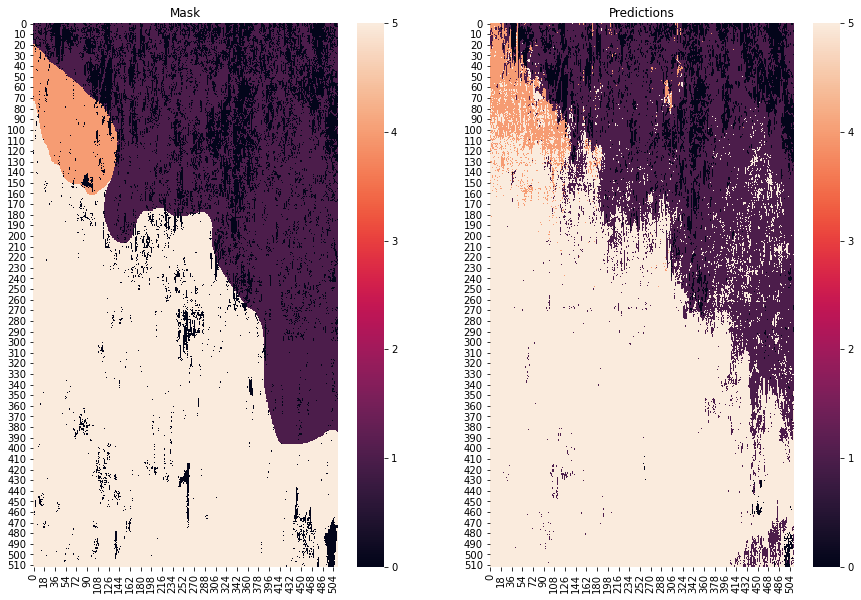

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
sns.heatmap(mask, ax=ax1)
sns.heatmap(predictions_map, ax=ax2)
ax1.set_title('Mask')
ax2.set_title('Predictions')

## Вывод

Исходя из полученных результатов можно сделать вывод, что точность модели повышается с увеличением количества признаков, участвующих в обучении